<a href="https://colab.research.google.com/github/beamaia/steel-plates-arcelor/blob/main/notebooks/desafio_beatriz_maia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

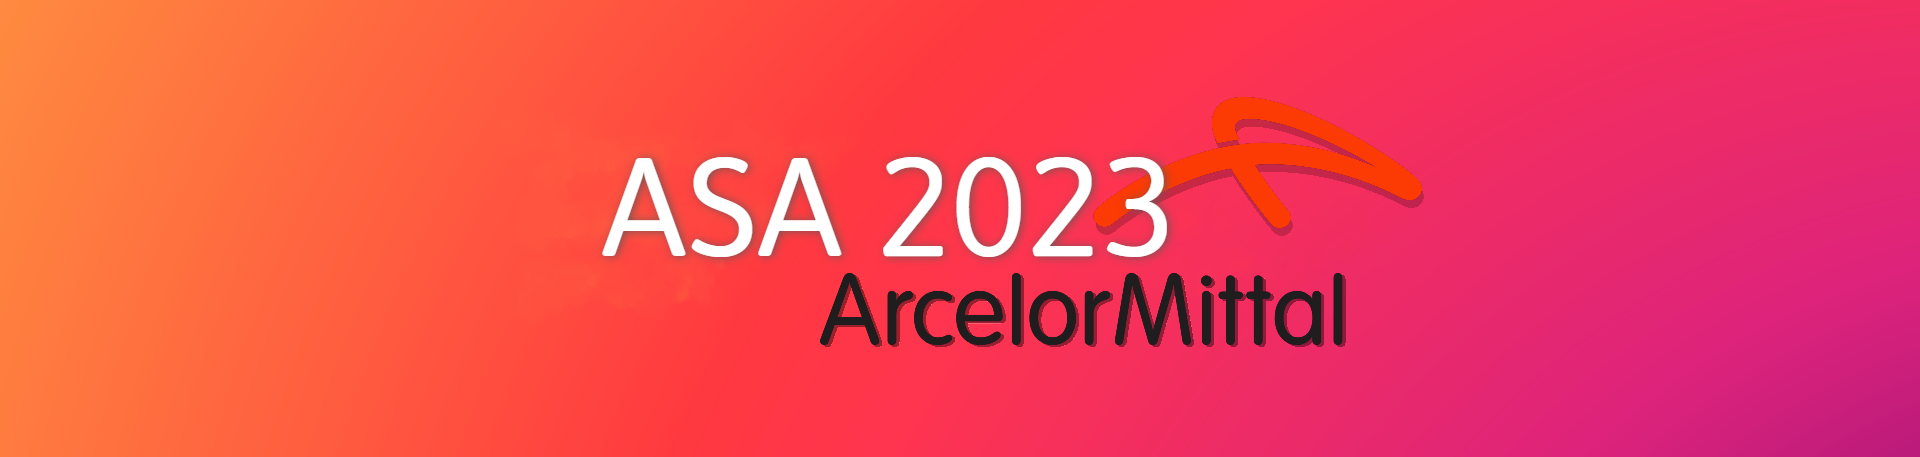

# Desafio ASA 2023 - Beatriz Maia



Este notebook possui uma análise exploratório de dados para um problema de placas de aços dentro do contexto da Arcelor Mittal para o desafio ASA 2023. Além do código e visualizações, este notebook terá comentários trazendo uma perspectiva mais narrativa do processo de pensamento que tive durante o problema.

## Descrição do problema

A ArcelorMittal está procurando formas de melhorar sua identificação de defeitos nas placas de aço. As placas são produzidas no lingotamento contínuo, após um processo de várias etapas que começa nos altos-fornos. Por causa da
complexidade do processo, diversos defeitos podem ocorrer na placa produzida. Nosso especialista gerou um conjunto de dados contendo dois defeitos que ele gostaria de distinguir com maior exatidão. Todos os dados foram obtidos a
partir de sensores automatizados ou imagens de câmeras, que identificam dimensões e características da placa e do defeito.
Você deve encontrar insights a partir dos dados e auxiliar o time de qualidade da ArcelorMittal a identificar se o defeito encontrado na placa é do tipo **0** ou do tipo **1**.

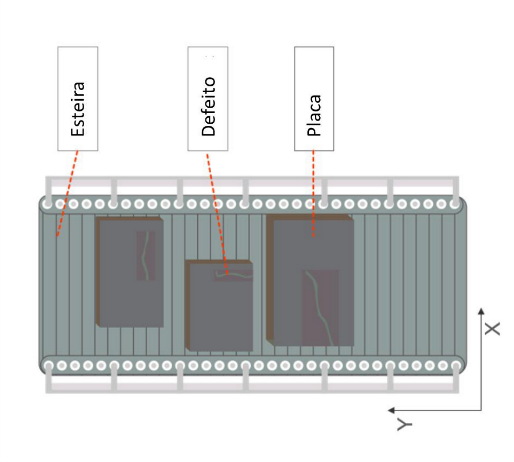

### Dicas
* Realizar a carga dos dados e analisar os tipos e características das colunas;
* Realizar a análise exploratória para comunicar as informações relevantes encontradas sobre os dados (utilize textos e gráficos);
* Aplicar métodos de detecção de outliers;
* Caso seja necessário para o tipo de modelo que você escolheu utilizar,realizar o pré-processamento, contendo tratamento de nulos, encoding e normalização, conforme visto no treinamento;
* Realizar o treino do modelo utilizando validação cruzada (cross validation), justificando a escolha do modelo utilizado;
* Calcular todas métricas de desempenho estudadas. Recomendamos utilizar o F1 como métrica principal.
* Responder as perguntas propostas;
* Anotar todas as suas descobertas e análises que podem contribuir para melhorar o desempenho do modelo e do processo de tomada de decisão.

### Dicionário de dados

- **min_x_defect**: Coordenada x inicial do defeito
- **max_x_ defect**: Coordenada x final do defeito
- **min_y_ defect**: Coordenada y inicial do defeito
- **max_y_ defect**: Coordenada y final do defeito
- **area_pixels**: Total de pixels presentes na placa
- **slab_width**: Largura da placa (eixo X)
- **slab_length**: Comprimento da placa (eixo Y)  
- **sum_pixel_luminosity**: Soma da luminosidade dos pixels
- **min_pixel_luminosity**: Mínima luminosidade dos pixels
- **max_pixel_luminosity**: Máxima luminosidade dos pixels  
- **conveyer_width**: Largura da esteira (correia) transportadora (eixo X)
- **type_of_steel**: Identifica a classe do aço: pode pertencer à classe A300 ou A400
- **defect_type**: Tipo de defeito da classe. Pode ser do tipo 0 ou do tipo 1.

***

## Imports e configurações

In [132]:
%pylab inline
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from matplotlib import patches
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, zscore, chi2
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

import sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn.model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.random.seed(42)

## Leitura dos dados

Para a leitura de dados, é importante preencher a variável `DATA_PATH` com o caminho completo para o seu arquivo.

In [ ]:
DATA_PATH = r'drive/MyDrive/ASA 2023/beatriz_maia/data/estudo_de_caso.csv'
DATA_DELIMITER = ','

In [ ]:
raw_df = pd.read_csv(DATA_PATH, delimiter=DATA_DELIMITER)
raw_df.head(10)

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type
0,38.0,49.0,735612.0,735624.0,113.0,11.0,12.0,12652.0,93.0,130.0,1707.0,100.0,TypeOfSteel_A300,1
1,1252.0,1348.0,355940.0,356016.0,1812.0,119.0,135.0,196003.0,NaN,132.0,1687.0,80.0,TypeOfSteel_A300,1
2,193.0,210.0,612201.0,612252.0,588.0,18.0,51.0,62182.0,73.0,135.0,1353.0,290.0,TypeOfSteel_A400,1
3,1159.0,1170.0,32914.0,32926.0,106.0,11.0,12.0,12792.0,100.0,134.0,1353.0,185.0,TypeOfSteel_A400,1
4,366.0,392.0,228379.0,228429.0,612.0,46.0,52.0,71337.0,103.0,127.0,1687.0,200.0,TypeOfSteel_A400,1
5,837.0,850.0,231429.0,231443.0,155.0,13.0,14.0,16093.0,55.0,134.0,1687.0,200.0,TypeOfSteel_A400,1
6,390.0,402.0,2513153.0,2513182.0,247.0,14.0,29.0,26419.0,NaN,126.0,1387.0,50.0,TypeOfSteel_A400,1
7,1351.0,1360.0,4807459.0,4807479.0,135.0,12.0,21.0,13096.0,NaN,109.0,1387.0,50.0,TypeOfSteel_A400,1
8,1325.0,1336.0,4848223.0,4848269.0,376.0,13.0,47.0,37703.0,NaN,117.0,1387.0,50.0,TypeOfSteel_A400,1
9,542.0,564.0,51943.0,51952.0,132.0,32.0,20.0,14760.0,104.0,119.0,1227.0,40.0,TypeOfSteel_A400,1


## Análise exploratório e transformações dos dados

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   min_x_defect          967 non-null    float64
 1   max_x_defect          967 non-null    float64
 2   min_y_defect          967 non-null    float64
 3   max_y_defect          967 non-null    float64
 4   area_pixels           967 non-null    float64
 5   slab_width            967 non-null    float64
 6   slab_length           967 non-null    float64
 7   sum_pixel_luminosity  967 non-null    float64
 8   min_pixel_luminosity  729 non-null    float64
 9   max_pixel_luminosity  967 non-null    float64
 10  conveyer_width        967 non-null    float64
 11  slab_thickness        967 non-null    float64
 12  type_of_steel         967 non-null    object 
 13  defect_type           967 non-null    int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 105.9+ KB


In [ ]:
raw_df.isna().sum(axis=0)

min_x_defect              0
max_x_defect              0
min_y_defect              0
max_y_defect              0
area_pixels               0
slab_width                0
slab_length               0
sum_pixel_luminosity      0
min_pixel_luminosity    238
max_pixel_luminosity      0
conveyer_width            0
slab_thickness            0
type_of_steel             0
defect_type               0
dtype: int64

In [ ]:
total_nan = 238

### Analisando a distribuição dos dados

Para saber quais tipos de transformações podem ser feitas, acho interessante ter uma noção de como os dados estão distribuídos. Desta forma, por exemplo, quando tiver analisando a melhor estratégia para preencher valores nulos, e tiver buscando relações ou posíveis porquês, há um conhecimento prévio de como os dados se comportam originalmente.

Nos nossos dados, há apenas uma coluna com valores nulos. Outro passo que devemos explorar, mas será em outro tópico, será dos tipos adequados dos dados.


In [ ]:
raw_df.head(5)

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type
0,38.0,49.0,735612.0,735624.0,113.0,11.0,12.0,12652.0,93.0,130.0,1707.0,100.0,TypeOfSteel_A300,1
1,1252.0,1348.0,355940.0,356016.0,1812.0,119.0,135.0,196003.0,NaN,132.0,1687.0,80.0,TypeOfSteel_A300,1
2,193.0,210.0,612201.0,612252.0,588.0,18.0,51.0,62182.0,73.0,135.0,1353.0,290.0,TypeOfSteel_A400,1
3,1159.0,1170.0,32914.0,32926.0,106.0,11.0,12.0,12792.0,100.0,134.0,1353.0,185.0,TypeOfSteel_A400,1
4,366.0,392.0,228379.0,228429.0,612.0,46.0,52.0,71337.0,103.0,127.0,1687.0,200.0,TypeOfSteel_A400,1


Nosso dado possui 12 colunas de dados discretos e 2 de dados categóricos.

In [ ]:
raw_df.drop(columns=['defect_type']).describe()

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness
count,967.000000,967.000000,9.670000e+02,9.670000e+02,967.000000,967.000000,967.000000,9.670000e+02,729.000000,967.000000,967.000000,967.000000
mean,723.846949,748.890383,1.674985e+06,1.675013e+06,467.441572,44.491210,36.544984,4.957048e+04,95.779150,129.839710,1498.494312,92.645295
std,494.305219,492.757755,1.892184e+06,1.892181e+06,1733.723575,85.896681,59.870839,1.814585e+05,28.647619,19.304366,158.154829,62.971298
min,0.000000,4.000000,6.712000e+03,6.724000e+03,15.000000,4.000000,2.000000,1.826000e+03,0.000000,37.000000,1227.000000,40.000000
25%,253.000000,283.000000,3.959620e+05,3.960710e+05,80.000000,14.000000,12.000000,9.005500e+03,77.000000,124.000000,1360.000000,40.000000
50%,753.000000,778.000000,1.046565e+06,1.046583e+06,133.000000,21.000000,19.000000,1.489600e+04,101.000000,127.000000,1373.000000,70.000000
75%,1122.500000,1141.500000,2.326936e+06,2.326952e+06,261.500000,41.000000,34.000000,2.872150e+04,112.000000,135.000000,1687.000000,100.000000
max,1705.000000,1713.000000,1.280650e+07,1.280652e+07,37334.000000,1275.000000,903.000000,3.918209e+06,203.000000,253.000000,1794.000000,300.000000


In [ ]:
def histogram_with_boxplot(dataframe: pd.DataFrame, column_analyzed: str, hex_code: str, title_text_prefix: str, xaxis_text: str) -> None:
    fig = px.histogram(data_frame=dataframe, x=column_analyzed, histfunc="avg", text_auto=True, opacity=0.8, color_discrete_sequence=[hex_code])
    fig.update_layout(
        title_text=f'Frequência {title_text_prefix}',
        xaxis_title_text=xaxis_text,
        yaxis_title_text='Quantidade',
    )
    fig.show()

    fig = px.box(data_frame=dataframe, x=column_analyzed, color_discrete_sequence=[hex_code])
    fig.update_layout(
        title_text=f'Boxplot {title_text_prefix}',
        xaxis_title_text=xaxis_text
    )
    fig.show()


histogram_with_boxplot(raw_df, 'area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(raw_df, 'slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(raw_df, 'slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(raw_df, 'sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(raw_df, 'min_pixel_luminosity', '#e12477', 'dos valores mínimos da luminosidade dos pixels', 'Mínima luminosidade dos pixels')
histogram_with_boxplot(raw_df, 'max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')
histogram_with_boxplot(raw_df, 'conveyer_width', '#f42c5c', 'da largura da esteira transportadora', 'Largura da esteira transportadora')

As colunas `area_pixels`, `slab_width`, `slab_length`, `sum_pixel_luminosity` e `max_pixel_luminosity` possuem valores com uma alta discrepância entre as os valores que ocorrem com maior frequência e os possíveis outliers. Há outras colunas que apresentam a possibilidade de outliers, mas elas serão analisadas cada posteriormente. Os histogramas das coordenadas não foram plotadas pois esses valores apenas possuem significados dentro do escopo das placas. Para isso, foram criadas novas colunas:

- defect_width: Largura do defeito na placa.
- defect_lenght: Comprimento do defeito na placa.
- defect_percentage: Porcentage do defeito em comparação a área da placa.

In [ ]:
#min_x_defect	max_x_defect	min_y_defect	max_y_defect	area_pixels	slab_width	slab_length
raw_df['defect_width'] = raw_df['max_x_defect'] - raw_df['min_x_defect']
raw_df['defect_length'] = raw_df['max_y_defect'] - raw_df['min_y_defect']
raw_df['defect_area'] = raw_df['defect_length']  * raw_df['defect_width']
raw_df['defect_percentage'] = raw_df['defect_area'] / (raw_df['slab_width'] * raw_df['slab_length'])
raw_df[['defect_width', 'defect_length', 'defect_percentage', 'defect_area']]

,defect_width,defect_length,defect_percentage,defect_area
0,11.0,12.0,1.000000,132.0
1,96.0,76.0,0.454155,7296.0
2,17.0,51.0,0.944444,867.0
3,11.0,12.0,1.000000,132.0
4,26.0,50.0,0.543478,1300.0
...,...,...,...,...
962,33.0,19.0,0.408735,627.0
963,49.0,28.0,0.386588,1372.0
964,31.0,17.0,0.499053,527.0
965,29.0,15.0,0.494318,435.0


Com essas colunas criadas, podemos ver a frequência em termo de porcentagem de área afetada. Podendo visualizar melhor uma possível informação que as coordenadas iria trazer.

In [ ]:
fig = px.histogram(data_frame=raw_df, x='defect_percentage', histfunc="avg", text_auto=True, opacity=0.8, color_discrete_sequence=['#f4345c'])
fig.update_layout(
    title_text='Frequência da porcentagem de área afetada das placas',
    xaxis_title_text='Porcentagem da área afetada das placas',
    yaxis_title_text='Quantidade',
)
fig.show()

Outra forma possível de visualizar a coordenada x é ver o seu posicionamento em relação a esteira.

In [ ]:
raw_df['conveyer_per_traveled'] = (raw_df['max_x_defect'] + raw_df['min_x_defect'])/2 / raw_df['conveyer_width']
raw_df[['conveyer_per_traveled']]

,conveyer_per_traveled
0,0.025483
1,0.770599
2,0.148928
3,0.860680
4,0.224659
...,...
962,0.112868
963,0.193015
964,0.117279
965,0.117279


In [ ]:
fig = px.histogram(data_frame=raw_df, x='conveyer_per_traveled', histfunc="avg", text_auto=True, nbins=10, opacity=0.8, color_discrete_sequence=['#ff785c'])
fig.update_layout(
    title_text='Frequência da porcentagem da esteira percorrida onde se encontrou o defeito',
    xaxis_title_text='Porcentagem da esteira percorrida',
    yaxis_title_text='Quantidade',
)
fig.show()

In [ ]:
raw_df['defect_type'].value_counts(normalize=True)

0    0.62668
1    0.37332
Name: defect_type, dtype: float64

Os dados estão desbalanceados, sendo ~37% defeito tipo 1 e ~63% defeito tipo 0.

Analisando quantidade de outliers nos dados:

In [ ]:
outliers = raw_df.copy()
outliers.drop(columns=['type_of_steel', 'defect_type', 'min_x_defect', 'min_y_defect', 'max_x_defect', 'max_y_defect'], inplace=True) # remove valores nao numericos e coordenadas

q1 = outliers.quantile(0.25)
q3 = outliers.quantile(0.75)
iqr = q3-q1
mask = (outliers < (q1 - 1.5 * iqr)) | (outliers > (q3 + 1.5 * iqr))

mask.sum()

area_pixels              131
slab_width                95
slab_length               94
sum_pixel_luminosity     128
min_pixel_luminosity      30
max_pixel_luminosity     126
conveyer_width             0
slab_thickness           116
defect_width              80
defect_length             98
defect_area              124
defect_percentage          0
conveyer_per_traveled      0
dtype: int64

Há uma grande quantidade de valores outlier, não há como utilizar a estratégia de removê-los. Os valores de coordenadas foram removidos devido ao fato que eles por si só não representam algo, precisam estar referenciando algo no espaço.

In [ ]:
outlier_per_row = mask.sum(axis=1)
all_outliers = raw_df[outlier_per_row > 0]
outlier_per_row

0      0
1      7
2      3
3      0
4      4
      ..
962    0
963    5
964    0
965    0
966    0
Length: 967, dtype: int64

In [ ]:
all_outliers.isna().sum(axis=0)

min_x_defect              0
max_x_defect              0
min_y_defect              0
max_y_defect              0
area_pixels               0
slab_width                0
slab_length               0
sum_pixel_luminosity      0
min_pixel_luminosity     74
max_pixel_luminosity      0
conveyer_width            0
slab_thickness            0
type_of_steel             0
defect_type               0
defect_width              0
defect_length             0
defect_area               0
defect_percentage         0
conveyer_per_traveled     0
dtype: int64

In [ ]:
74/total_nan # porcentagem dos valores em que min_pixel_luminosity eh nulo em all_outliers

0.31092436974789917

In [ ]:
len(all_outliers)/len(raw_df) # porcentagem dos valores de linhas com outliers em relacao ao total do dataset. Porcentagem acima eh aproximadamente igual.

0.33712512926577043

In [ ]:
for i in range(1, len(mask.columns)):
    outliers_amount = (outlier_per_row >= i).sum()
    print(f"There are {outliers_amount} rows with {i} columns with outliers in them or more")
    print(f"That is {outliers_amount / len(raw_df) * 100}% of the dataset. New size would be: {len(raw_df) - outliers_amount}.\n")

There are 326 rows with 1 columns with outliers in them or more
That is 33.71251292657704% of the dataset. New size would be: 641.

There are 187 rows with 2 columns with outliers in them or more
That is 19.33815925542916% of the dataset. New size would be: 780.

There are 137 rows with 3 columns with outliers in them or more
That is 14.167528438469493% of the dataset. New size would be: 830.

There are 119 rows with 4 columns with outliers in them or more
That is 12.306101344364013% of the dataset. New size would be: 848.

There are 105 rows with 5 columns with outliers in them or more
That is 10.858324715615305% of the dataset. New size would be: 862.

There are 85 rows with 6 columns with outliers in them or more
That is 8.790072388831438% of the dataset. New size would be: 882.

There are 48 rows with 7 columns with outliers in them or more
That is 4.963805584281282% of the dataset. New size would be: 919.

There are 14 rows with 8 columns with outliers in them or more
That is 1.44

Explorando como ficaria se fosse retirar uma porção, optando por remover linhas em que pelo menos 6 colunas apresentam valores outliers.

In [ ]:
multiple_rows_outliers = raw_df[outlier_per_row >= 6]
multiple_rows_outliers.head()

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
1,1252.0,1348.0,355940.0,356016.0,1812.0,119.0,135.0,196003.0,NaN,132.0,1687.0,80.0,TypeOfSteel_A300,1,96.0,76.0,7296.0,0.454155,0.770599
74,1641.0,1665.0,2961860.0,2961953.0,1130.0,102.0,101.0,99671.0,77.0,103.0,1692.0,70.0,TypeOfSteel_A300,1,24.0,93.0,2232.0,0.216657,0.976950
75,1633.0,1656.0,2987424.0,2987515.0,1125.0,83.0,92.0,100842.0,76.0,111.0,1692.0,70.0,TypeOfSteel_A300,1,23.0,91.0,2093.0,0.274096,0.971927
117,206.0,239.0,1785718.0,1785787.0,979.0,126.0,108.0,118187.0,106.0,141.0,1660.0,100.0,TypeOfSteel_A300,1,33.0,69.0,2277.0,0.167328,0.134036
193,1259.0,1302.0,3928519.0,3928612.0,2400.0,96.0,95.0,260185.0,69.0,132.0,1664.0,40.0,TypeOfSteel_A400,1,43.0,93.0,3999.0,0.438487,0.769531


In [ ]:
multiple_rows_outliers_mask = mask.iloc[multiple_rows_outliers.index]
multiple_rows_outliers_mask.head()

,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
1,True,True,True,True,False,False,False,False,True,True,True,False,False
74,True,True,True,True,False,True,False,False,False,True,True,False,False
75,True,True,True,True,False,False,False,False,False,True,True,False,False
117,True,True,True,True,False,False,False,False,False,True,True,False,False
193,True,True,True,True,False,False,False,False,True,True,True,False,False


Verificando a razão dos outliers por coluna. É importante verificar se a classe target foi afetada, além de quais colunas mais possuem outliers.

In [ ]:
for column in multiple_rows_outliers_mask.columns:
    display(multiple_rows_outliers_mask[column].value_counts(normalize=True))
    print()

len(multiple_rows_outliers_mask)

True    1.0
Name: area_pixels, dtype: float64

True     0.858824
False    0.141176
Name: slab_width, dtype: float64

True     0.941176
False    0.058824
Name: slab_length, dtype: float64

True     0.976471
False    0.023529
Name: sum_pixel_luminosity, dtype: float64

False    0.870588
True     0.129412
Name: min_pixel_luminosity, dtype: float64

False    0.752941
True     0.247059
Name: max_pixel_luminosity, dtype: float64

False    1.0
Name: conveyer_width, dtype: float64

False    0.694118
True     0.305882
Name: slab_thickness, dtype: float64

False    0.505882
True     0.494118
Name: defect_width, dtype: float64

True     0.788235
False    0.211765
Name: defect_length, dtype: float64

True    1.0
Name: defect_area, dtype: float64

False    1.0
Name: defect_percentage, dtype: float64

False    1.0
Name: conveyer_per_traveled, dtype: float64

85

In [ ]:
multiple_rows_outliers['defect_type'].value_counts(normalize=True)

0    0.858824
1    0.141176
Name: defect_type, dtype: float64

In [ ]:
multiple_rows_outliers['defect_type'].value_counts()

0    73
1    12
Name: defect_type, dtype: int64

In [ ]:
round(12/(raw_df['defect_type'] == 1).sum() * 100, 2) # porcentagem da quantia de defeitos do tipo 1 removido pela quantidade original

3.32

Há 85 linhas que possuem pelo menos 6 colunas como valores outliers, no qual essas colunas não incluem as colunas de coordenadas ou a `type_of_steel`. Isso seria aproximadamente remoção 8.79% dos dados. Além disso, estariamos removendo dados da classe majoritária, a classe de defeito 1 não estaria sendo afetada, perdendo 12 amostras (~3.32%).

In [ ]:
few_outliers_df = raw_df.drop(index=multiple_rows_outliers_mask.index)
few_outliers_df

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
0,38.0,49.0,735612.0,735624.0,113.0,11.0,12.0,12652.0,93.0,130.0,1707.0,100.0,TypeOfSteel_A300,1,11.0,12.0,132.0,1.000000,0.025483
2,193.0,210.0,612201.0,612252.0,588.0,18.0,51.0,62182.0,73.0,135.0,1353.0,290.0,TypeOfSteel_A400,1,17.0,51.0,867.0,0.944444,0.148928
3,1159.0,1170.0,32914.0,32926.0,106.0,11.0,12.0,12792.0,100.0,134.0,1353.0,185.0,TypeOfSteel_A400,1,11.0,12.0,132.0,1.000000,0.860680
4,366.0,392.0,228379.0,228429.0,612.0,46.0,52.0,71337.0,103.0,127.0,1687.0,200.0,TypeOfSteel_A400,1,26.0,50.0,1300.0,0.543478,0.224659
5,837.0,850.0,231429.0,231443.0,155.0,13.0,14.0,16093.0,55.0,134.0,1687.0,200.0,TypeOfSteel_A400,1,13.0,14.0,182.0,1.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,137.0,170.0,301492.0,301511.0,304.0,59.0,26.0,35778.0,111.0,126.0,1360.0,40.0,TypeOfSteel_A400,0,33.0,19.0,627.0,0.408735,0.112868
963,238.0,287.0,315114.0,315142.0,671.0,91.0,39.0,86424.0,119.0,143.0,1360.0,40.0,TypeOfSteel_A400,0,49.0,28.0,1372.0,0.386588,0.193015
964,144.0,175.0,340581.0,340598.0,287.0,44.0,24.0,34599.0,112.0,133.0,1360.0,40.0,TypeOfSteel_A400,0,31.0,17.0,527.0,0.499053,0.117279
965,145.0,174.0,386779.0,386794.0,292.0,40.0,22.0,37572.0,120.0,140.0,1360.0,40.0,TypeOfSteel_A400,0,29.0,15.0,435.0,0.494318,0.117279


In [ ]:
histogram_with_boxplot(few_outliers_df, 'area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(few_outliers_df, 'slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(few_outliers_df, 'slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(few_outliers_df, 'sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(few_outliers_df, 'min_pixel_luminosity', '#e12477', 'dos valores mínimos da luminosidade dos pixels', 'Mínima luminosidade dos pixels')
histogram_with_boxplot(few_outliers_df, 'max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')
histogram_with_boxplot(few_outliers_df, 'conveyer_width', '#f42c5c', 'da largura da esteira transportadora', 'Largura da esteira transportadora')

Como dito anteriormente, há diversos valores outliers no dataset. Analisando deu para perceber que enquanto existe varios desses valores que ocorrem simultanemante junto com outros, a remoção de uma parte ainda resultaria na permanência de outliers. Essa exploração foi mais para compreender os valores dos dados. Idealmente estes dados devem ser tratados com diferentes estratégias, que serão melhor abordadas na seção `Corrigindo outliers`. Colunas que precisaram possivelmente ser tratadas são:


*   area_pixels
*   slab_width
*   slab_length
*   sum_pixel_luminosity
*   min_pixel_luminosity
*   max_pixel_luminosity



### Corrigindo valores categóricos

In [ ]:
raw_df.head(5)

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
0,38.0,49.0,735612.0,735624.0,113.0,11.0,12.0,12652.0,93.0,130.0,1707.0,100.0,TypeOfSteel_A300,1,11.0,12.0,132.0,1.000000,0.025483
1,1252.0,1348.0,355940.0,356016.0,1812.0,119.0,135.0,196003.0,NaN,132.0,1687.0,80.0,TypeOfSteel_A300,1,96.0,76.0,7296.0,0.454155,0.770599
2,193.0,210.0,612201.0,612252.0,588.0,18.0,51.0,62182.0,73.0,135.0,1353.0,290.0,TypeOfSteel_A400,1,17.0,51.0,867.0,0.944444,0.148928
3,1159.0,1170.0,32914.0,32926.0,106.0,11.0,12.0,12792.0,100.0,134.0,1353.0,185.0,TypeOfSteel_A400,1,11.0,12.0,132.0,1.000000,0.860680
4,366.0,392.0,228379.0,228429.0,612.0,46.0,52.0,71337.0,103.0,127.0,1687.0,200.0,TypeOfSteel_A400,1,26.0,50.0,1300.0,0.543478,0.224659


In [ ]:
raw_df['type_of_steel'].value_counts()

TypeOfSteel_A400    478
TypeOfSteel_A300    470
TypeOfStel_A300      10
TypeOfSteel_????      9
Name: type_of_steel, dtype: int64

In [ ]:
categorical_df = raw_df.copy()
categorical_df[categorical_df['type_of_steel'] == 'TypeOfStel_A300'] = 'TypeOfSteel_A300'

In [ ]:
categorical_df['type_of_steel'].value_counts()

TypeOfSteel_A300    480
TypeOfSteel_A400    478
TypeOfSteel_????      9
Name: type_of_steel, dtype: int64

In [ ]:
unknown_steel_df = categorical_df[categorical_df['type_of_steel'] == 'TypeOfSteel_????'].copy()
unknown_steel_df

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
269,832.0,856.0,310567.0,310597.0,335.0,39.0,31.0,35066.0,NaN,127.0,1690.0,70.0,TypeOfSteel_????,1,24.0,30.0,720.0,0.595533,0.499408
270,671.0,682.0,334988.0,335000.0,101.0,12.0,12.0,11471.0,NaN,140.0,1690.0,70.0,TypeOfSteel_????,1,11.0,12.0,132.0,0.916667,0.400296
275,1128.0,1141.0,643180.0,643193.0,124.0,17.0,13.0,13135.0,NaN,127.0,1686.0,70.0,TypeOfSteel_????,1,13.0,13.0,169.0,0.764706,0.672894
279,1457.0,1466.0,1928741.0,1928773.0,192.0,24.0,32.0,19002.0,NaN,125.0,1688.0,70.0,TypeOfSteel_????,1,9.0,32.0,288.0,0.375,0.865818
398,25.0,33.0,3277804.0,3277821.0,91.0,15.0,17.0,10957.0,105.0,141.0,1658.0,100.0,TypeOfSteel_????,0,8.0,17.0,136.0,0.533333,0.017491
399,1343.0,1351.0,46714.0,46725.0,56.0,11.0,11.0,5729.0,NaN,117.0,1362.0,70.0,TypeOfSteel_????,0,8.0,11.0,88.0,0.727273,0.988987
400,0.0,4.0,224005.0,224035.0,83.0,18.0,31.0,7446.0,71.0,108.0,1360.0,70.0,TypeOfSteel_????,0,4.0,30.0,120.0,0.215054,0.001471
436,272.0,284.0,226474.0,226495.0,187.0,20.0,21.0,13351.0,49.0,101.0,1362.0,200.0,TypeOfSteel_????,0,12.0,21.0,252.0,0.6,0.204112
457,344.0,353.0,2278012.0,2278020.0,46.0,10.0,8.0,5003.0,95.0,127.0,1354.0,80.0,TypeOfSteel_????,0,9.0,8.0,72.0,0.9,0.257386


In [ ]:
unknown_steel_df['defect_type'].value_counts(normalize=True) # alta porcentagem de 1 sao linha com min_pixel_luminosity faltante, porem poucos exemplos. Idealmente seria bom nao retira-los

0    0.555556
1    0.444444
Name: defect_type, dtype: float64

In [ ]:
known_steel_df = categorical_df[categorical_df['type_of_steel'] != 'TypeOfSteel_????'].copy()
known_steel_df['type_of_steel'].value_counts(normalize=True)

TypeOfSteel_A300    0.501044
TypeOfSteel_A400    0.498956
Name: type_of_steel, dtype: float64

De acordo com o dicionário de dados sabemos que:

```
Identifica a classe do aço: pode pertencer à classe A300 ou A400
```

Porém, há 9 casos no dataset em que o tipo de aço está com o valor "TypeOfSteel_????". A coluna `type_of_steel` é bastante balanceada, com o tipo 'TypeOfSteel_A300' sendo aproximadamente 50.10% do dataset. Se formos utilizar a estratégia de preencher este valor com o valor mais frequente (de maior probabilidade). Existe a estratégia de utilizar um outro modelo para poder agrupar essas linhas em qual tipo aço ela pertence, porém sinto que por termos poucos exemplos, essa estratégia acaba tendo pouco impacto nos nossos dados.

Uma observação é que todos os valores que possuem defeito tipo 1 possuem a coluna `min_pixel_luminosity` vazia. Se formos remover os casos que possuem este valor faltante, acabaríamos influenciando mais na classe de defeito tipo 1 do que a classe de defeito tipo 0, mesmo se em uma escala pequena.

Em primeira instâncias, tentando ter uma política uqe busca reservar os dados, foi decidido utilizar o valor da classe com maior frequência.

In [ ]:
categorical_df[categorical_df['type_of_steel'] == 'TypeOfSteel_????'] = 'TypeOfSteel_A300' # como ha poucos valores, nao vejo necessidade de usar os imputters

In [ ]:
categorical_df = categorical_df.replace({
    'TypeOfSteel_A300': 0,
    'TypeOfSteel_A400' : 1
})

In [ ]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   min_x_defect           967 non-null    float64
 1   max_x_defect           967 non-null    float64
 2   min_y_defect           967 non-null    float64
 3   max_y_defect           967 non-null    float64
 4   area_pixels            967 non-null    float64
 5   slab_width             967 non-null    float64
 6   slab_length            967 non-null    float64
 7   sum_pixel_luminosity   967 non-null    float64
 8   min_pixel_luminosity   736 non-null    float64
 9   max_pixel_luminosity   967 non-null    float64
 10  conveyer_width         967 non-null    float64
 11  slab_thickness         967 non-null    float64
 12  type_of_steel          967 non-null    int64  
 13  defect_type            967 non-null    int64  
 14  defect_width           967 non-null    float64
 15  defect

### Analisando min_pixel_luminosity

De início, pode-se observar que os nossos dados possui apenas uma coluna com valores nulos: min_pixel_luminosity. De acordo com nosso dicionário de dados, essa variável representa a mínima luminosidade dos pixels. Os dados são obtidos através de sensores ou imagens, não temos detalhes a respeito de qual sensor foi utilizado, mas sabemos pelas colunas `min_pixel_luminosity` e `max_pixel_luminosity`, que o valor pode pelo menos variar entre [0, 253]. Há no total 238 casos em que este valor nao está preenchido, sendo aproximadamente um quarto de nossos dados.

In [ ]:
categorical_df['min_pixel_luminosity'].describe()

count    736.000000
mean      93.675272
std       32.029735
min        0.000000
25%       75.750000
50%      101.000000
75%      112.000000
max      203.000000
Name: min_pixel_luminosity, dtype: float64

In [ ]:
categorical_df['max_pixel_luminosity'].describe()

count    967.000000
mean     127.404343
std       26.351088
min        0.000000
25%      123.000000
50%      127.000000
75%      135.000000
max      253.000000
Name: max_pixel_luminosity, dtype: float64

In [ ]:
categorical_df['min_pixel_luminosity'].isna().sum(axis=0) / len(categorical_df['min_pixel_luminosity'])

0.23888314374353672

In [ ]:
temp_zero_strategy = categorical_df['min_pixel_luminosity'].copy()
temp_zero_strategy = temp_zero_strategy.fillna(0)
temp_zero_strategy.describe()

count    967.000000
mean      71.297828
std       48.761602
min        0.000000
25%        0.000000
50%       95.000000
75%      107.000000
max      203.000000
Name: min_pixel_luminosity, dtype: float64

In [ ]:
histogram_with_boxplot(temp_zero_strategy, 'min_pixel_luminosity', '#fc7141', 'de min_pixel_luminosity', 'min_pixel_luminosity')

In [ ]:
nan_mim_pix_df = categorical_df[raw_df['min_pixel_luminosity'].isna()]
no_nan_mim_pix_df = categorical_df.drop(index=list(nan_mim_pix_df.index))

In [ ]:
no_nan_mim_pix_df[['min_pixel_luminosity', 'max_pixel_luminosity']].corr()

,min_pixel_luminosity,max_pixel_luminosity
min_pixel_luminosity,1.000000,0.689786
max_pixel_luminosity,0.689786,1.000000


In [ ]:
no_nan_mim_pix_df['min_pixel_luminosity'].describe()

count    729.000000
mean      94.574760
std       30.831521
min        0.000000
25%       76.000000
50%      101.000000
75%      112.000000
max      203.000000
Name: min_pixel_luminosity, dtype: float64

In [ ]:
no_nan_mim_pix_df['max_pixel_luminosity'].describe()

count    729.000000
mean     129.684499
std       26.296895
min        0.000000
25%      124.000000
50%      132.000000
75%      140.000000
max      253.000000
Name: max_pixel_luminosity, dtype: float64

In [ ]:
(no_nan_mim_pix_df['max_pixel_luminosity'] >= no_nan_mim_pix_df['min_pixel_luminosity']).value_counts()

True    729
dtype: int64

Há algumas estratégias existentes que foram rejeitas. A primeira é de utilizar o valor 0.

Essa estratégias não seria a melhor. Podemos observar o valor do primeiro quartil, percebemos que esse valor é de 75.75. Existe a possibilidade de que este número está sendo jogado para cima, e se todos estes valores representasse o menor valor possível, o primeiro quartil seria 0 (valor suspeito, aumentando consideravelmente a área deste quartil). A média também acaba sendo afetada, reduzindo bastante, com o desvio indo de 32.03 (sem valores preenchidos) para 48.71. Esse comportamento pode até ser o real, porém ser compreensão sobre o domínio, os sensores utilizados e os problemas comum que podem ocorrer, não é possível fazer esse tipo de decisão, ela introduz um comportamente muito diferente aos dados.

A outra possibilidade é de preencher com o valor da média, mas ao observar uma tabela sem as linhas com valores faltantes, percebemos a alta correlação entre `min_pixel_luminosity` e `max_pixel_luminosity`, o que era de se esperar. Com essa relação, todos os valores de `max_pixel_luminosity` são maiores que ou iguais a `min_pixel_luminosity` em uma dada linha. Como existe valores de `max_pixel_luminosity` abaixo da média de `min_pixel_luminosity`, essa estratégia não seria a ideal.

In [ ]:
corr_no_df = no_nan_mim_pix_df.corr().abs()
corr_no_df['min_pixel_luminosity'].sort_values(ascending=False)

min_pixel_luminosity     1.000000
max_pixel_luminosity     0.689786
type_of_steel            0.315677
defect_length            0.260915
area_pixels              0.213491
slab_length              0.212310
sum_pixel_luminosity     0.183059
defect_area              0.173806
conveyer_width           0.162389
slab_width               0.130628
defect_width             0.062213
max_x_defect             0.047524
defect_type              0.043386
min_x_defect             0.040672
max_y_defect             0.032112
min_y_defect             0.032106
defect_percentage        0.025455
slab_thickness           0.008010
conveyer_per_traveled    0.004386
Name: min_pixel_luminosity, dtype: float64

In [ ]:
# max_pixel_luminosity     0.689786
# type_of_steel            0.315677
# defect_length            0.260915
# area_pixels              0.213491
# slab_length              0.212310
# sum_pixel_luminosity     0.183059
# defect_area              0.173806
# conveyer_width           0.162389
# slab_width               0.130628

In [ ]:
strategy1 = categorical_df.copy()
strategy1 = strategy1.sort_values(by=['max_pixel_luminosity', 'type_of_steel', 'defect_length']) # estrategia usando valores com colunas com maior corr
strategy1 = strategy1.fillna(method='pad')

strategy2 = categorical_df.copy()
strategy2 = strategy2.sort_values(by=['max_pixel_luminosity']) # estrategia com valores com coluna de maior corr
strategy2 = strategy2.fillna(method='pad')

strategy3 = categorical_df.copy()
strategy3 = strategy3.sort_values(by=['max_pixel_luminosity', 'defect_length', 'area_pixels']) # estrategia com valores com coluna de maior corr, antes de ter type_of_steel
strategy3 = strategy3.fillna(method='pad')

strategy4 = categorical_df.copy()
strategy4 = strategy4.sort_values(by=['max_pixel_luminosity', 'type_of_steel', 'conveyer_width']) # hipotese minha
strategy4 = strategy4.fillna(method='pad')

strategy5 = categorical_df.copy()
strategy5 = strategy5.sort_values(by=['conveyer_width', 'defect_percentage', 'max_pixel_luminosity']) # hipotese minha
strategy5 = strategy5.fillna(method='pad')

strategy6 = categorical_df.copy()
strategy6 = strategy6.sort_values(by=['conveyer_width', 'max_pixel_luminosity']) # hipotese minha
strategy6 = strategy6.fillna(method='pad')

In [ ]:
real_population = sorted(no_nan_mim_pix_df['min_pixel_luminosity'])

samp_strg1 = sorted(strategy1['min_pixel_luminosity'])
print(1, ttest_ind(real_population, samp_strg1))

samp_strg2 = sorted(strategy2['min_pixel_luminosity'])
print(2, ttest_ind(real_population, samp_strg2))

samp_strg3 = sorted(strategy3['min_pixel_luminosity'])
print(3, ttest_ind(real_population, samp_strg3))

samp_strg4 = sorted(strategy4['min_pixel_luminosity'])
print(4, ttest_ind(real_population, samp_strg4))

samp_strg5 = sorted(strategy5['min_pixel_luminosity'])
print(5, ttest_ind(real_population, samp_strg5))

samp_strg6 = sorted(strategy6['min_pixel_luminosity'])
print(6, ttest_ind(real_population, samp_strg6))

print('zeros', ttest_ind(real_population, temp_zero_strategy))

1 TtestResult(statistic=2.1809826184494643, pvalue=0.0293218361750566, df=1694.0)
2 TtestResult(statistic=1.572283092053618, pvalue=0.11607165482541451, df=1694.0)
3 TtestResult(statistic=0.8923428193152023, pvalue=0.3723359467427002, df=1694.0)
4 TtestResult(statistic=2.3023707124252124, pvalue=0.021435012173456964, df=1694.0)
5 TtestResult(statistic=0.40214457283427346, pvalue=0.6876283647382551, df=1694.0)
6 TtestResult(statistic=1.6708921628392468, pvalue=0.0949276951269587, df=1694.0)
zeros TtestResult(statistic=11.297764893078075, pvalue=1.3781537876844715e-28, df=1694.0)


Strategy2 e strategy3 (e a estratégia com zeros preenchendo os valores nulos) rejeitam a hipotese nula que ambas a população da estratégia sendo investigada quanto a original (de valores conhecidos preenchidos) são iguais. A população que possue o menor pvalue é a Strategy4, em que seus valores foram primeiro organizados de forma crescente considerando a coluna `max_pixel_luminosity`, depois `conveyer_width` e por último `defect_percentage`. A escolha dessa ordem foi com base nos valores que estavam correlacionados com `min_pixel_luminosity`.

Essa organização por ordem crescente foi necessário para aplicar a estratégia de preencher o valor faltante com o último valor ('ffill'). Como o `max_pixel_luminosity` era maior que `min_pixel_luminosity`, era importante que os valores fosse organizados, pois dessa forma sempre podemos garantir que o valor anterior seria menor que o `max_pixel_luminosity`, pois foi menor que o `max_pixel_luminosity` anterior.

In [ ]:
post_nan_df = strategy4.copy()

In [ ]:
post_nan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967 entries, 34 to 532
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   min_x_defect           967 non-null    float64
 1   max_x_defect           967 non-null    float64
 2   min_y_defect           967 non-null    float64
 3   max_y_defect           967 non-null    float64
 4   area_pixels            967 non-null    float64
 5   slab_width             967 non-null    float64
 6   slab_length            967 non-null    float64
 7   sum_pixel_luminosity   967 non-null    float64
 8   min_pixel_luminosity   967 non-null    float64
 9   max_pixel_luminosity   967 non-null    float64
 10  conveyer_width         967 non-null    float64
 11  slab_thickness         967 non-null    float64
 12  type_of_steel          967 non-null    int64  
 13  defect_type            967 non-null    int64  
 14  defect_width           967 non-null    float64
 15  defec

In [ ]:
post_nan_df.head()

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
post_nan_df['min_pixel_luminosity'].isna().sum()

0

In [ ]:
(post_nan_df['max_pixel_luminosity'] > post_nan_df['min_pixel_luminosity']).sum()

948

In [ ]:
(post_nan_df['max_pixel_luminosity'] == post_nan_df['min_pixel_luminosity']).sum()

19

In [ ]:
len(post_nan_df)

967

### Removendo valores impossíveis

Uma observação feita enquanto estava analisando eram os valores de linha para quando `max_pixel_luminosity`. Enquanto existe a possibilidade de um sensor ou imagem detectar um pixel de luminosidade 0, é estranho quando valores físicos como de `slab_width` e `sbal_legth` são de 0. Isso significa que existe um defeito que tem 0 em comprimento e largura. Poderia representar a possibilidade de um problema de escala se o valor de 0 não se repetisse para todas as outras colunas também.

Com isso em mente, esses valores foram removidos.

In [ ]:
zero_values = post_nan_df[(post_nan_df['slab_width'] == 0) | (post_nan_df['slab_length'] == 0)]
zero_values

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
no_zero_values = post_nan_df.drop(index=zero_values.index)
no_zero_values.head()

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
726,484.0,555.0,1466087.0,1466141.0,1241.0,183.0,102.0,22191.0,0.0,37.0,1650.0,69.0,0,0,71.0,54.0,3834.0,0.205400,0.314848
729,61.0,99.0,4757479.0,4757628.0,1970.0,210.0,181.0,29002.0,0.0,39.0,1346.0,100.0,0,0,38.0,149.0,5662.0,0.148961,0.059435
860,344.0,355.0,113753.0,113766.0,92.0,12.0,13.0,4690.0,29.0,71.0,1356.0,300.0,0,0,11.0,13.0,143.0,0.916667,0.257743
861,42.0,53.0,141291.0,141311.0,135.0,19.0,20.0,7015.0,36.0,71.0,1356.0,300.0,0,0,11.0,20.0,220.0,0.578947,0.035029
607,1295.0,1308.0,4061997.0,4062020.0,138.0,25.0,25.0,7331.0,21.0,79.0,1348.0,40.0,1,0,13.0,23.0,299.0,0.478400,0.965504


In [ ]:
(no_zero_values['max_pixel_luminosity'] > no_zero_values['min_pixel_luminosity']).sum()

948

In [ ]:
len(no_zero_values)

948

In [ ]:
no_zero_values.describe()

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
count,948.000000,948.000000,9.480000e+02,9.480000e+02,948.000000,948.000000,948.000000,9.480000e+02,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,725.617089,750.874473,1.684128e+06,1.684156e+06,473.108650,44.943038,36.900844,5.019885e+04,92.947257,129.957806,1496.097046,93.014768,0.504219,0.366034,25.257384,28.837553,1023.350211,0.563585,0.493866
std,493.263607,491.672808,1.904633e+06,1.904630e+06,1750.382491,86.675955,60.402091,1.831999e+05,27.792818,19.393777,157.680458,63.391576,0.500246,0.481973,59.993305,42.644660,3942.250239,0.239820,0.322362
min,0.000000,8.000000,6.712000e+03,6.724000e+03,15.000000,4.000000,2.000000,1.826000e+03,0.000000,37.000000,1227.000000,40.000000,0.000000,0.000000,3.000000,2.000000,20.000000,0.048387,0.002371
25%,255.500000,290.750000,3.975858e+05,3.976882e+05,80.000000,14.000000,12.000000,9.031750e+03,73.000000,124.000000,1360.000000,40.000000,0.000000,0.000000,10.000000,11.000000,129.500000,0.366482,0.179497
50%,754.000000,781.500000,1.047791e+06,1.047805e+06,133.000000,22.000000,19.000000,1.495400e+04,99.000000,127.000000,1373.000000,70.000000,1.000000,0.000000,14.000000,17.000000,224.500000,0.575235,0.510832
75%,1122.250000,1142.500000,2.350142e+06,2.350201e+06,263.500000,41.000000,34.000000,2.891825e+04,110.000000,135.000000,1687.000000,100.000000,1.000000,1.000000,22.000000,27.000000,506.000000,0.764706,0.789315
max,1705.000000,1713.000000,1.280650e+07,1.280652e+07,37334.000000,1275.000000,903.000000,3.918209e+06,203.000000,253.000000,1794.000000,300.000000,1.000000,1.000000,1186.000000,412.000000,74178.000000,1.000000,0.996501


### Corringdo outliers

Colunas que devemos analisar utilizando o método de z-scale:

*  area_pixels
* slab_width
* slab_length
* sum_pixel_luminosity
* min_pixel_luminosity
* max_pixel_luminosity

A outra estratégia que podemos utilizar seria de "re-escalar" utilizando uma outra função como log x.

In [ ]:
def scatter_plot(dataframe: pd.DataFrame, x: str, y: str, color: str = None) -> None:
    fig = px.scatter(data_frame=dataframe, x=x, y=y, color=color)
    fig.update_layout(
        xaxis_title_text=x,
        yaxis_title_text=y,
    )
    fig.show()

In [ ]:
outliers = no_zero_values.copy()
outliers['zscore_area_pixels'] = abs(zscore(outliers['area_pixels']))
outliers['zscore_slab_width'] = abs(zscore(outliers['slab_width']))
outliers['zscore_slab_length'] = abs(zscore(outliers['slab_length']))
outliers['zscore_sum_pixel_luminosity'] = abs(zscore(outliers['sum_pixel_luminosity']))
outliers['zscore_min_pixel_luminosity'] = abs(zscore(outliers['min_pixel_luminosity']))
outliers['zscore_max_pixel_luminosity'] = abs(zscore(outliers['max_pixel_luminosity']))

outliers['zscore_outlier'] = abs(zscore(outliers['area_pixels'])) > 1
outliers['zscore_outlier'] = abs(zscore(outliers['slab_width'])) > 1
outliers['zscore_outlier'] = abs(zscore(outliers['slab_length'])) > 1
outliers['zscore_outlier'] = abs(zscore(outliers['sum_pixel_luminosity'])) > 1
outliers['zscore_outlier'] = abs(zscore(outliers['min_pixel_luminosity'])) > 1
outliers['zscore_outlier'] = abs(zscore(outliers['max_pixel_luminosity'])) > 1

In [ ]:
outliers['zscore_outlier'].value_counts()

False    774
True     174
Name: zscore_outlier, dtype: int64

In [ ]:
outliers['zscore_outlier'].value_counts(normalize=True)

False    0.816456
True     0.183544
Name: zscore_outlier, dtype: float64

In [ ]:
histogram_with_boxplot(outliers, 'zscore_area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(outliers, 'zscore_slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(outliers, 'zscore_slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(outliers, 'zscore_sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(outliers, 'zscore_min_pixel_luminosity', '#e12477', 'dos valores mínimos da luminosidade dos pixels', 'Mínima luminosidade dos pixels')
histogram_with_boxplot(outliers, 'zscore_max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')

In [ ]:
rescaling = no_zero_values.copy()
rescaling['log_area_pixels'] = np.log(rescaling['area_pixels'])
rescaling['log_slab_width'] = np.log(rescaling['slab_width'])
rescaling['log_slab_length'] = np.log(rescaling['slab_length'])
rescaling['log_sum_pixel_luminosity'] = np.log(rescaling['sum_pixel_luminosity'])
# rescaling['log_min_pixel_luminosity'] = np.log(rescaling['min_pixel_luminosity']) -> ocorre divisao por zero
rescaling['log_max_pixel_luminosity'] = np.log(rescaling['max_pixel_luminosity'])

In [ ]:
histogram_with_boxplot(rescaling, 'log_area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(rescaling, 'log_slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(rescaling, 'log_slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(rescaling, 'log_sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(rescaling, 'log_max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')

In [ ]:
rescaling_outliers = rescaling.copy()
rescaling_outliers['zscore_area_pixels'] = abs(zscore(rescaling_outliers['log_area_pixels']))
rescaling_outliers['zscore_slab_width'] = abs(zscore(rescaling_outliers['log_slab_width']))
rescaling_outliers['zscore_slab_length'] = abs(zscore(rescaling_outliers['log_slab_length']))
rescaling_outliers['zscore_sum_pixel_luminosity'] = abs(zscore(rescaling_outliers['log_sum_pixel_luminosity']))
rescaling_outliers['zscore_max_pixel_luminosity'] = abs(zscore(rescaling_outliers['log_max_pixel_luminosity']))

rescaling_outliers['zscore_outlier'] = abs(zscore(rescaling_outliers['log_area_pixels'])) > 1
rescaling_outliers['zscore_outlier'] = abs(zscore(rescaling_outliers['log_slab_width'])) > 1
rescaling_outliers['zscore_outlier'] = abs(zscore(rescaling_outliers['log_slab_length'])) > 1
rescaling_outliers['zscore_outlier'] = abs(zscore(rescaling_outliers['log_sum_pixel_luminosity'])) > 1
rescaling_outliers['zscore_outlier'] = abs(zscore(rescaling_outliers['log_max_pixel_luminosity'])) > 1

In [ ]:
histogram_with_boxplot(rescaling_outliers, 'zscore_area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(rescaling_outliers, 'zscore_slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(rescaling_outliers, 'zscore_slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(rescaling_outliers, 'zscore_sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(rescaling_outliers, 'zscore_max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_lognormal = np.random.RandomState(616).lognormal(size=(3, 3))

power_transform_areas_pixels = pt.fit_transform(no_zero_values['area_pixels'].to_numpy().reshape(-1, 1))
power_transform_slab_length = pt.fit_transform(no_zero_values['slab_length'].to_numpy().reshape(-1, 1))
power_transform_slab_width = pt.fit_transform(no_zero_values['slab_width'].to_numpy().reshape(-1, 1))
power_transform_sum_pixel_luminosity = pt.fit_transform(no_zero_values['sum_pixel_luminosity'].to_numpy().reshape(-1, 1))
power_transform_min_pixel_luminosity = pt.fit_transform(no_zero_values['min_pixel_luminosity'].to_numpy().reshape(-1, 1))
power_transform_max_pixel_luminosity = pt.fit_transform(no_zero_values['max_pixel_luminosity'].to_numpy().reshape(-1, 1))

power_transform_df = no_zero_values.copy()
power_transform_df['trans_area_pixels'] = power_transform_areas_pixels
power_transform_df['trans_slab_length'] = power_transform_slab_length
power_transform_df['trans_slab_width'] = power_transform_slab_width
power_transform_df['trans_sum_pixel_luminosity'] = power_transform_sum_pixel_luminosity
power_transform_df['trans_min_pixel_luminosity'] = power_transform_min_pixel_luminosity
power_transform_df['trans_max_pixel_luminosity'] = power_transform_max_pixel_luminosity

In [ ]:
histogram_with_boxplot(power_transform_df, 'trans_area_pixels', '#fc7141', 'da área dos pixeis das placas', 'Área dos pixeis da placa')
histogram_with_boxplot(power_transform_df, 'trans_slab_width', '#fc5440', 'da largura das placas', 'Largura da placa')
histogram_with_boxplot(power_transform_df, 'trans_slab_length', '#ec2c67', 'do comprimento das placas', 'Comprimento da placa')
histogram_with_boxplot(power_transform_df, 'trans_sum_pixel_luminosity', '#ce207c', 'da soma da luminosidade dos pixels', 'Soma da luminosidade dos pixels')
histogram_with_boxplot(power_transform_df, 'trans_min_pixel_luminosity', '#e12477', 'dos valores mínimos da luminosidade dos pixels', 'Mínima luminosidade dos pixels')
histogram_with_boxplot(power_transform_df, 'trans_max_pixel_luminosity', '#fc3849', 'dos valores máximos da luminosidade dos pixels', 'Máxima luminosidade dos pixels')

In [ ]:
# Utilizando distancia de -- Tentativa de detectar outliers de formar multivariacional
# Fonte: https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3
# Utilizando valores sem o powertransform
no_zero_values = no_zero_values.reset_index(drop=True)
df = no_zero_values[['area_pixels', 'slab_width', 'slab_length', 'sum_pixel_luminosity', 'min_pixel_luminosity', 'max_pixel_luminosity']].to_numpy()

# calcular o ponto central
covariance  = np.cov(df , rowvar=False)
covariance_pm1 = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(df , axis=0)

distances = []
for i, val in enumerate(df):
      p1 = val
      p2 = centerpoint
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# "We also need to find a cutoff value from the Chi-Square distribution.
# The reason why Chi-Square is used to find cutoff value is, Mahalanobis
# Distance returns the distance as squared (D² ). We should also take the
# quantile value as 0.95 while finding cutoff because the points outside
# the 0.95 (two-tailed) will be considered as an outlier." -> da secao do artigo sobre o uso
cutoff = chi2.ppf(0.95, df.shape[1]) # Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers


outlier_indexes = np.where(distances > cutoff )

print('Index of Outliers')
print(outlier_indexes)

Index of Outliers
(array([  0,   1,  21,  35,  38,  60,  62,  65,  83, 113, 154, 215, 221,
       251, 263, 264, 298, 316, 319, 443, 447, 465, 475, 486, 505, 591,
       592, 620, 629, 651, 665, 673, 682, 685, 717, 744, 752, 763, 814,
       828, 854, 866, 895, 905, 914, 918, 927, 928, 929, 932, 933, 934,
       935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947]),)


In [ ]:
no_zero_values.iloc[outlier_indexes]

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
0,484.0,555.0,1466087.0,1466141.0,1241.0,183.0,102.0,22191.0,0.0,37.0,1650.0,69.0,0,0,71.0,54.0,3834.0,0.205400,0.314848
1,61.0,99.0,4757479.0,4757628.0,1970.0,210.0,181.0,29002.0,0.0,39.0,1346.0,100.0,0,0,38.0,149.0,5662.0,0.148961,0.059435
21,19.0,28.0,39680.0,39849.0,1170.0,99.0,174.0,67967.0,29.0,93.0,1362.0,200.0,1,0,9.0,169.0,1521.0,0.088297,0.017254
35,0.0,21.0,881709.0,881856.0,1949.0,68.0,162.0,144252.0,56.0,99.0,1687.0,80.0,0,0,21.0,147.0,3087.0,0.280229,0.006224
38,0.0,14.0,990037.0,990193.0,1183.0,80.0,162.0,91488.0,57.0,101.0,1687.0,80.0,0,0,14.0,156.0,2184.0,0.168519,0.004149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,795.0,802.0,96606.0,96620.0,55.0,10.0,14.0,11560.0,203.0,220.0,1387.0,40.0,1,0,7.0,14.0,98.0,0.700000,0.575703
944,526.0,676.0,1470973.0,1471038.0,1939.0,192.0,116.0,239860.0,109.0,247.0,1692.0,80.0,0,0,150.0,65.0,9750.0,0.437769,0.355201
945,360.0,998.0,4601186.0,4601217.0,11797.0,705.0,225.0,1290423.0,109.0,252.0,1358.0,100.0,0,0,638.0,31.0,19778.0,0.124684,0.500000
946,90.0,131.0,906500.0,906534.0,571.0,58.0,43.0,62823.0,73.0,252.0,1692.0,80.0,0,1,41.0,34.0,1394.0,0.558941,0.065307


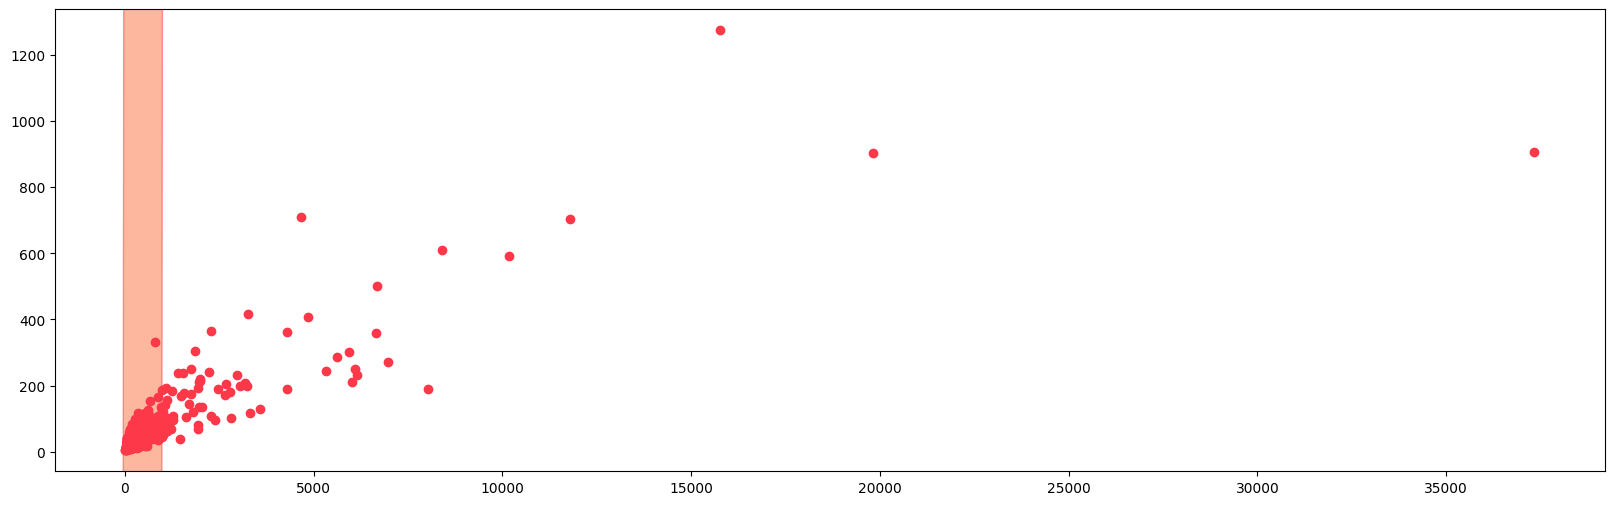

In [ ]:
## Finding ellipse dimensions
pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)

# Ellipse patch
ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                  width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#fc3849')
ellipse.set_facecolor('#fc7141')
ellipse.set_alpha(0.5)

fig = plt.figure(figsize=(20,6))
ax = plt.subplot()
ax.add_artist(ellipse)
plt.scatter(df[: , 0], df[ : , 1], color='#fc3849')
plt.show()

In [ ]:
no_zero_values.iloc[outlier_indexes]['defect_type'].value_counts()

0    61
1     4
Name: defect_type, dtype: int64

In [ ]:
65 / len(no_zero_values)

0.06856540084388185

In [ ]:
# Utilizando valores com o powertransform
power_transform_df = power_transform_df.reset_index(drop=True)
df = power_transform_df[['trans_area_pixels', 'trans_slab_width', 'trans_slab_length', 'trans_sum_pixel_luminosity', 'trans_min_pixel_luminosity', 'trans_max_pixel_luminosity']].to_numpy()

# calcular o ponto central
covariance  = np.cov(df , rowvar=False)
covariance_pm1 = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(df , axis=0)

distances = []
for i, val in enumerate(df):
      p1 = val
      p2 = centerpoint
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

cutoff = chi2.ppf(0.95, df.shape[1]) # Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers
outlier_indexes2 = np.where(distances > cutoff )

print('Index of Outliers')
print(outlier_indexes2)

Index of Outliers
(array([  0,   1,   2,   3,   4,   5,   6,   8,  10,  12,  14,  15,  19,
        20,  30,  31,  34,  56,  96, 117, 118, 144, 215, 237, 257, 263,
       264, 298, 371, 443, 495, 629, 651, 654, 673, 685, 704, 747, 752,
       765, 828, 863, 866, 877, 889, 894, 900, 905, 906, 907, 908, 909,
       914, 918, 920, 922, 923, 925, 926, 927, 928, 929, 930, 931, 932,
       933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945,
       946, 947]),)


In [ ]:
power_transform_df.iloc[outlier_indexes2] # Esse valores sofreram transformacao com os outliers anteriormente, talvez essa ordem nao seria a mais ideal

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,...,defect_length,defect_area,defect_percentage,conveyer_per_traveled,trans_area_pixels,trans_slab_length,trans_slab_width,trans_sum_pixel_luminosity,trans_min_pixel_luminosity,trans_max_pixel_luminosity
0,484.0,555.0,1466087.0,1466141.0,1241.0,183.0,102.0,22191.0,0.0,37.0,...,54.0,3834.0,0.205400,0.314848,2.310765,2.025196,1.707856,2.531365,0.000000,8.038393
1,61.0,99.0,4757479.0,4757628.0,1970.0,210.0,181.0,29002.0,0.0,39.0,...,149.0,5662.0,0.148961,0.059435,2.333545,2.095779,1.715240,2.536663,0.000000,8.252830
2,344.0,355.0,113753.0,113766.0,92.0,12.0,13.0,4690.0,29.0,71.0,...,13.0,143.0,0.916667,0.257743,2.060927,1.586697,1.370877,2.486966,50.948628,11.042761
3,42.0,53.0,141291.0,141311.0,135.0,19.0,20.0,7015.0,36.0,71.0,...,20.0,220.0,0.578947,0.035029,2.115976,1.708077,1.463743,2.501136,66.022324,11.042761
4,1295.0,1308.0,4061997.0,4062020.0,138.0,25.0,25.0,7331.0,21.0,79.0,...,23.0,299.0,0.478400,0.965504,2.118883,1.764084,1.510372,2.502557,34.655687,11.614112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,795.0,802.0,96606.0,96620.0,55.0,10.0,14.0,11560.0,203.0,220.0,...,14.0,98.0,0.700000,0.575703,1.972755,1.608855,1.328480,2.515910,534.363571,18.517888
944,526.0,676.0,1470973.0,1471038.0,1939.0,192.0,116.0,239860.0,109.0,247.0,...,65.0,9750.0,0.437769,0.355201,2.332832,2.042512,1.710495,2.563782,251.324027,19.488314
945,360.0,998.0,4601186.0,4601217.0,11797.0,705.0,225.0,1290423.0,109.0,252.0,...,31.0,19778.0,0.124684,0.500000,2.390392,2.118451,1.760982,2.574045,251.324027,19.660845
946,90.0,131.0,906500.0,906534.0,571.0,58.0,43.0,62823.0,73.0,252.0,...,34.0,1394.0,0.558941,0.065307,2.261367,1.882189,1.619203,2.549215,154.728531,19.660845


Após alguns experimentos, concluo que a melhor forma de lidar com os outliers seria a técnica utilizando a distancia de Mahalanobis Distance, por ela levar em consideração uma analise multivariada. No início da seção da análise, percebeu-se que muito desses valores ocorrem de forma simultanea a outros valores. Muitas vezes uma linha tinha múltiplas colunas com valores de outlier utilizando a técnica de IQR. Com a técnica de z-score e de reescalar os valores, percebemos que os outliers continuam na distribuição. Trnasformar algumas das colunas com a função de log ainda adiciona o limite que os valores não podem ser igual a zero. Contudo, mesmo se queiramos abordar uma política mais conservadora em termos de manter os dados, a opção para os 65 valores reconhecidos como outliers será de descartá-los.

In [ ]:
no_outliers = no_zero_values.drop(index=list(outlier_indexes)[0])

In [ ]:
no_outliers

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_type,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
2,344.0,355.0,113753.0,113766.0,92.0,12.0,13.0,4690.0,29.0,71.0,1356.0,300.0,0,0,11.0,13.0,143.0,0.916667,0.257743
3,42.0,53.0,141291.0,141311.0,135.0,19.0,20.0,7015.0,36.0,71.0,1356.0,300.0,0,0,11.0,20.0,220.0,0.578947,0.035029
4,1295.0,1308.0,4061997.0,4062020.0,138.0,25.0,25.0,7331.0,21.0,79.0,1348.0,40.0,1,0,13.0,23.0,299.0,0.478400,0.965504
5,1680.0,1689.0,990614.0,990624.0,68.0,10.0,10.0,3507.0,21.0,82.0,1692.0,70.0,0,1,9.0,10.0,90.0,0.900000,0.995567
6,1616.0,1625.0,1725137.0,1725163.0,138.0,23.0,26.0,8720.0,48.0,84.0,1656.0,80.0,0,0,9.0,26.0,234.0,0.391304,0.978563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,110.0,117.0,90910.0,90937.0,116.0,18.0,28.0,19935.0,162.0,181.0,1353.0,100.0,1,0,7.0,27.0,189.0,0.375000,0.083888
925,131.0,138.0,106169.0,106180.0,34.0,9.0,12.0,5942.0,167.0,182.0,1353.0,200.0,1,0,7.0,11.0,77.0,0.712963,0.099409
926,1247.0,1273.0,120090.0,120110.0,301.0,38.0,46.0,51176.0,160.0,182.0,1353.0,200.0,1,0,26.0,20.0,520.0,0.297483,0.931264
930,40.0,56.0,15755.0,15765.0,102.0,17.0,10.0,17813.0,162.0,189.0,1353.0,100.0,1,0,16.0,10.0,160.0,0.941176,0.035477


### Normalizando os dados

In [ ]:
features_df = no_outliers.copy()
features_df = features_df.reset_index(drop=True)

target_df = features_df['defect_type']
features_df = features_df.drop(columns=['defect_type'])

In [ ]:
# Primeiro mapiando os valores para uma distribucao gausiana
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_lognormal = np.random.RandomState(616).lognormal(size=(3, 3))

power_transform_areas_pixels = pt.fit_transform(no_outliers['area_pixels'].to_numpy().reshape(-1, 1))
power_transform_slab_length = pt.fit_transform(no_outliers['slab_length'].to_numpy().reshape(-1, 1))
power_transform_slab_width = pt.fit_transform(no_outliers['slab_width'].to_numpy().reshape(-1, 1))
power_transform_sum_pixel_luminosity = pt.fit_transform(no_outliers['sum_pixel_luminosity'].to_numpy().reshape(-1, 1))
power_transform_min_pixel_luminosity = pt.fit_transform(no_outliers['min_pixel_luminosity'].to_numpy().reshape(-1, 1))
power_transform_max_pixel_luminosity = pt.fit_transform(no_outliers['max_pixel_luminosity'].to_numpy().reshape(-1, 1))

features_df['area_pixels'] = power_transform_areas_pixels
features_df['slab_length'] = power_transform_slab_length
features_df['slab_width'] = power_transform_slab_width
features_df['sum_pixel_luminosity'] = power_transform_sum_pixel_luminosity
features_df['min_pixel_luminosity'] = power_transform_min_pixel_luminosity
features_df['max_pixel_luminosity'] = power_transform_max_pixel_luminosity

In [ ]:
scaler = MinMaxScaler()
print(scaler.fit_transform(features_df))
print(scaler.data_max_)

[[2.01759531e-01 2.03519062e-01 8.36271990e-03 ... 5.09063819e-03
  9.06716418e-01 2.56880077e-01]
 [2.46334311e-02 2.63929619e-02 1.05141626e-02 ... 8.27746048e-03
  5.28672427e-01 3.28512498e-02]
 [7.59530792e-01 7.62463343e-01 3.16824512e-01 ... 1.15470574e-02
  4.16119403e-01 9.68819979e-01]
 ...
 [7.31378299e-01 7.41935484e-01 8.85780642e-03 ... 2.06936512e-02
  2.13600191e-01 9.34377220e-01]
 [2.34604106e-02 2.81524927e-02 7.06496352e-04 ... 5.79422233e-03
  9.34152766e-01 3.33011102e-02]
 [6.37536657e-01 6.51612903e-01 5.80330151e-03 ... 3.14543498e-03
  3.60341151e-01 6.53355123e-01]]
[1.70500000e+03 1.71300000e+03 1.28064950e+07 1.28065200e+07
 2.83302294e+00 1.92792228e+00 2.50691256e+00 3.34130641e+00
 2.09738628e+03 4.04984740e+02 1.79400000e+03 3.00000000e+02
 1.00000000e+00 2.26000000e+02 1.76000000e+02 2.41820000e+04
 1.00000000e+00 9.96501458e-01]


In [ ]:
features_norm_df = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)
features_norm_df.head(5)

,min_x_defect,max_x_defect,min_y_defect,max_y_defect,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_width,defect_length,defect_area,defect_percentage,conveyer_per_traveled
0,0.201760,0.203519,0.008363,0.008363,0.531832,0.435321,0.529432,0.306946,0.057865,0.000000,0.227513,1.000000,0.0,0.035874,0.063218,0.005091,0.906716,0.256880
1,0.024633,0.026393,0.010514,0.010515,0.611615,0.574798,0.629449,0.414324,0.083846,0.000000,0.227513,1.000000,0.0,0.035874,0.103448,0.008277,0.528672,0.032851
2,0.759531,0.762463,0.316825,0.316825,0.615901,0.646581,0.676983,0.425328,0.032260,0.061423,0.213404,0.000000,1.0,0.044843,0.120690,0.011547,0.416119,0.968820
3,0.985337,0.985924,0.076869,0.076868,0.461811,0.372935,0.463265,0.221195,0.032260,0.084740,0.820106,0.115385,0.0,0.026906,0.045977,0.002897,0.888060,0.999060
4,0.947801,0.948387,0.134254,0.134255,0.615901,0.625637,0.685039,0.467307,0.135335,0.100367,0.756614,0.153846,0.0,0.026906,0.137931,0.008857,0.318624,0.981955


In [ ]:
matrix_corr = features_norm_df.corr().round(3)
px.imshow(matrix_corr, text_auto=True, color_continuous_scale='plasma')

In [ ]:
features_norm_df = features_norm_df.drop(columns=['min_x_defect', 'max_x_defect', 'min_y_defect', 'max_y_defect'])

In [ ]:
matrix_corr = features_norm_df.corr().round(3).abs()
px.imshow(matrix_corr, text_auto=True, color_continuous_scale='plasma')

Correlação interessante entre comprimento da esteira com o tipo de aço: -0.468

As colunas [area_pixels, slab_width, slab_length, sum_pixel_luminosity] possuiam alta correlação entre si, quanto as colunas [defect_width, defect_length, defect_area, defect_percentage] com as colunas anteriores. Isso era de se esperar, visto que estes valores afetam largura e comprimento ou são relacionados com largura e comprimento. sum_pixel_luminosity é a soma dos pixels, dependendo da area da placa. A última coluna foram todos valores criados considerando as coordenadas, com defect_percentage sendo influenciada por slab_width e slab_length.

In [ ]:
features_norm_df = features_norm_df.drop(columns=['defect_width', 'defect_length', 'defect_area'])

In [ ]:
matrix_corr = features_norm_df.corr().round(3)
px.imshow(matrix_corr, text_auto=True, color_continuous_scale='plasma')

A correlação grande entre slab_width e slab_length pode indicar que há formas específicas de placas de aço. A correlação entre area_pixel e sum_pixel_luminosity também pode indicar que com o tamanho da area de pixel vai impactar em quantos pixels são detectados, portanto enquanto a área cresce, a a soma da luminosidade também.

In [ ]:
features_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area_pixels            883 non-null    float64
 1   slab_width             883 non-null    float64
 2   slab_length            883 non-null    float64
 3   sum_pixel_luminosity   883 non-null    float64
 4   min_pixel_luminosity   883 non-null    float64
 5   max_pixel_luminosity   883 non-null    float64
 6   conveyer_width         883 non-null    float64
 7   slab_thickness         883 non-null    float64
 8   type_of_steel          883 non-null    float64
 9   defect_percentage      883 non-null    float64
 10  conveyer_per_traveled  883 non-null    float64
dtypes: float64(11)
memory usage: 76.0 KB


In [ ]:
features_norm_df

,area_pixels,slab_width,slab_length,sum_pixel_luminosity,min_pixel_luminosity,max_pixel_luminosity,conveyer_width,slab_thickness,type_of_steel,defect_percentage,conveyer_per_traveled
0,0.531832,0.435321,0.529432,0.306946,0.057865,0.000000,0.227513,1.000000,0.0,0.906716,0.256880
1,0.611615,0.574798,0.629449,0.414324,0.083846,0.000000,0.227513,1.000000,0.0,0.528672,0.032851
2,0.615901,0.646581,0.676983,0.425328,0.032260,0.061423,0.213404,0.000000,1.0,0.416119,0.968820
3,0.461811,0.372935,0.463265,0.221195,0.032260,0.084740,0.820106,0.115385,0.0,0.888060,0.999060
4,0.615901,0.625637,0.685039,0.467307,0.135335,0.100367,0.756614,0.153846,0.0,0.318624,0.981955
...,...,...,...,...,...,...,...,...,...,...,...
878,0.581210,0.559670,0.700020,0.640581,0.952937,0.919209,0.222222,0.230769,1.0,0.300373,0.081998
879,0.274590,0.335023,0.509658,0.371574,1.000000,0.928152,0.222222,0.615385,1.0,0.678690,0.097611
880,0.749969,0.741095,0.792483,0.793275,0.934344,0.928152,0.222222,0.615385,1.0,0.213600,0.934377
881,0.554258,0.543314,0.463265,0.619382,0.952937,0.990990,0.222222,0.230769,1.0,0.934153,0.033301


In [ ]:
features_norm_df['type_of_steel'] = features_norm_df['type_of_steel'].astype(int)

In [ ]:
features_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area_pixels            883 non-null    float64
 1   slab_width             883 non-null    float64
 2   slab_length            883 non-null    float64
 3   sum_pixel_luminosity   883 non-null    float64
 4   min_pixel_luminosity   883 non-null    float64
 5   max_pixel_luminosity   883 non-null    float64
 6   conveyer_width         883 non-null    float64
 7   slab_thickness         883 non-null    float64
 8   type_of_steel          883 non-null    int64  
 9   defect_percentage      883 non-null    float64
 10  conveyer_per_traveled  883 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 76.0 KB


In [ ]:
target_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 883 entries, 0 to 882
Series name: defect_type
Non-Null Count  Dtype
--------------  -----
883 non-null    int64
dtypes: int64(1)
memory usage: 7.0 KB


## Treinamento dos modelos

In [ ]:
train_id, test_id = train_test_split(
  range(len(features_norm_df)),
  test_size=0.3,
  random_state = 38,
  stratify=target_df
) # tinha separado os dois antes do split, logo peguei os indices

In [ ]:
X_train, y_train = features_norm_df.iloc[train_id], target_df.iloc[train_id]
X_test, y_test = features_norm_df.iloc[test_id], target_df.iloc[test_id]

In [ ]:
model_grad = GradientBoostingClassifier(
   random_state=42,
   verbose=1
)

In [ ]:
param_grid_grad = {
   'max_depth': [3, 5, 7],
   'n_estimators': range(100, 500, 100),
   'learning_rate': [.0001, .001, 0.1, 1],
   'max_depth': range(3, 10),
   'max_features': range(5, len(X_train.columns)),
   'warm_start': [True, False]
}

In [114]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=38)

search = sklearn.model_selection.GridSearchCV(
    model_grad,
    param_grid=param_grid_grad,
    scoring='f1',
    cv=cv,
)

search.fit(X_train, y_train)

print('Melhor configuração do modelo:', search.best_params_)
print('Melhor score obtido:', search.best_score_)

model = search.best_estimator_

Streaming output truncated to the last 5000 lines.
         3           0.0660            0.47s
         4           0.0371            0.48s
         5           0.0191            0.47s
         6           0.0115            0.47s
         7           0.0083            0.45s
         8           0.0049            0.45s
         9           0.0029            0.44s
        10           0.0019            0.43s
        20           0.0000            0.38s
        30           0.0000            0.33s
        40           0.0000            0.23s
        50           0.0000            0.16s
        60           0.0000            0.11s
        70           0.0000            0.07s
        80           0.0000            0.04s
        90           0.0000            0.02s
       100           0.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4466            0.34s
         2           0.1947            0.36s
         3           0.1087            0.39s
   

In [115]:
model.score(X=X_test, y=y_test)

0.7169811320754716

In [123]:
search.best_params_

{'learning_rate': 1,
 'max_depth': 5,
 'max_features': 6,
 'n_estimators': 200,
 'warm_start': True}

In [120]:
search.best_estimator_.feature_importances_

array([0.07015643, 0.03476758, 0.03760868, 0.07141091, 0.11347408,
       0.09064047, 0.14529196, 0.09809715, 0.10061882, 0.1173606 ,
       0.1205733 ])

In [134]:
search.best_estimator_.feature_names_in_

array(['area_pixels', 'slab_width', 'slab_length', 'sum_pixel_luminosity',
       'min_pixel_luminosity', 'max_pixel_luminosity', 'conveyer_width',
       'slab_thickness', 'type_of_steel', 'defect_percentage',
       'conveyer_per_traveled'], dtype=object)

In [137]:
search_grad = search

In [135]:
model_ada= AdaBoostClassifier(
   random_state=42,
)

In [136]:
param_grid_ada = {
   'n_estimators': range(50, 300, 50),
   'learning_rate': [.0001, .001, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

In [ ]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=38)

search_ada = sklearn.model_selection.GridSearchCV(
    model_ada,
    param_grid=param_grid_ada,
    scoring='f1',
    cv=cv,
)

search_ada.fit(X_train, y_train)

In [141]:
print('Melhor configuração do modelo:', search_ada.best_params_)
print('Melhor score obtido:', search_ada.best_score_)
model_ada = search_ada.best_estimator_

Melhor configuração do modelo: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100}
Melhor score obtido: 0.6474559282227447


In [183]:
model_ada.score(X=X_test, y=y_test)

0.7018867924528301

In [216]:
search_ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100}

In [139]:
model_rand = RandomForestClassifier(
   random_state=42)

In [146]:
param_grid_rand = {
   'n_estimators': range(50, 300, 50),
   'max_depth': range(2, 9),
   'warm_start': [True, False],
   'max_samples': [0.6, 0.7, 0.8,],
   'max_features': range(5, len(X_train.columns)),
}

In [184]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=38)

search_rand = sklearn.model_selection.GridSearchCV(
    model_rand,
    param_grid=param_grid_rand,
    scoring='f1',
    cv=cv,
)

search_rand.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=38, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(2, 9), 'max_features': range(5, 11),
                         'max_samples': [0.6, 0.7, 0.8],
                         'n_estimators': range(50, 300, 50),
                         'warm_start': [True, False]},
             scoring='f1')

In [188]:
model_rand = search_rand.best_estimator_

In [189]:
search_rand.best_params_

{'max_depth': 8,
 'max_features': 7,
 'max_samples': 0.7,
 'n_estimators': 200,
 'warm_start': True}

In [192]:
model_rand.score(X=X_test, y=y_test)

0.7283018867924528

In [190]:
model = search_grad.best_estimator_

O intuito era fazer uma analise entre diferente modelos de ensemble. O melhor modelo, de acordo com a métrica F1, foi o GradientBoosting.

In [191]:
import pickle

filename = 'grad_model.sav'
pickle.dump(model, open(filename, 'wb'))

filename = 'ada_model.sav'
pickle.dump(model_ada, open(filename, 'wb'))

filename = 'ada_model.sav'
pickle.dump(model_rand, open(filename, 'wb'))

Sem remover as features

In [193]:
all_features_norm_df = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)

In [197]:
X_train, y_train = all_features_norm_df.iloc[train_id], target_df.iloc[train_id]
X_test, y_test = all_features_norm_df.iloc[test_id], target_df.iloc[test_id]

In [200]:
X_train.shape

(618, 18)

In [201]:
X_test.shape

(265, 18)

In [203]:
model_rand.feature_names_in_

array(['min_x_defect', 'max_x_defect', 'min_y_defect', 'max_y_defect',
       'area_pixels', 'slab_width', 'slab_length', 'sum_pixel_luminosity',
       'min_pixel_luminosity', 'max_pixel_luminosity', 'conveyer_width',
       'slab_thickness', 'type_of_steel', 'defect_width', 'defect_length',
       'defect_area', 'defect_percentage', 'conveyer_per_traveled'],
      dtype=object)

In [206]:
X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [209]:
hyp = {
 'max_depth': 8,
 'max_features': 7,
 'max_samples': 0.7,
 'n_estimators': 200,
 'warm_start': True,
 'random_state': 42
}

model_rand = RandomForestClassifier(**hyp)

In [210]:
model_rand.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=7, max_samples=0.7,
                       n_estimators=200, random_state=42, warm_start=True)

In [211]:
model_rand.score(X_test, y_test)

0.720754716981132

In [212]:
hyp = {'learning_rate': 1,
 'max_depth': 5,
 'max_features': 6,
 'n_estimators': 200,
 'warm_start': True,
 'random_state': 42}

model_grad = GradientBoostingClassifier(**hyp)

In [214]:
model_grad.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features=6,
                           n_estimators=200, random_state=42, warm_start=True)

In [215]:
model_grad.score(X_test, y_test)

0.7622641509433963

In [217]:
hyp = {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100, 'random_state': 42}

model_ada= AdaBoostClassifier(**hyp)

In [218]:
model_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

In [219]:
model_ada.score(X_test, y_test)

0.6830188679245283

In [220]:
model = model_grad

## Perguntas

**Questão 1**: O modelo construído será utilizado para reduzir o erro na hora da classificação do defeito. Sabe-se que:

* Cada acerto do modelo significa um custo de R\$ 500,00 para a recuperação da placa;
* Identificar o defeito 0 incorretamente como defeito 1 gera um custo de R\$ 500,00 para recuperação da placa  mais um custo de R$ 3500,00 por conta do custo logístico de ter enviado a placa para o tratamento incorreto;
* Identificar o defeito 1 incorretamente como defeito 0 gera um custo de R\$ 500,00 para a recuperação da placa. Além disso, há também um custo de R\$ 6213,00 por conta do erro logístico de ter enviado a placa para o tratamento incorreto, sabendo que o tratamento do defeito 1 ocorre numa etapa do processo anterior ao do defeito 0.

Em posse dessas informações, qual seria o custo total do processo com o uso em produção do modelo desenvolvido? Deixe bem claro todo o passo a passo utilizado para a obtenção do resultado.

In [221]:
y_pred = model.predict(X_test)
results = pd.DataFrame({'y_pred': y_pred, 'y_true': y_test})
results['custo'] = 0
results['recuperacao'] = 0

erros_0_1 = results[(results['y_pred'] == 0) & (results['y_true'] == 1)]
erros_1_0 = results[(results['y_pred'] == 1) & (results['y_true'] == 0)]
acertos = results[(results['y_pred'] == results['y_true'])]

erros_0_1['custo'] = 500 + 3500
erros_1_0['custo'] = 500 + 6213
acertos['recuperacao'] = 500

total_model = erros_0_1['custo'].sum() + erros_1_0['custo'].sum() - acertos['recuperacao'].sum()
total_model

237816

In [222]:
acertos.shape

(202, 4)

In [223]:
erros_0_1.shape

(31, 4)

In [224]:
erros_1_0.shape

(32, 4)

In [225]:
acertos.shape[0] / len(results)

0.7622641509433963

In [226]:
erros_0_1.shape[0] / len(results)

0.1169811320754717

In [227]:
erros_1_0.shape[0] / len(results)

0.12075471698113208

**Questão 2**: Sem uma ferramenta mais tecnológica ao seu dispor, atualmente a distinção dos dois defeitos é feita de forma manual por um especialista. Para esse conjunto de dados específico, ele obteve os seguintes resultados:

* 350 placas com defeito tipo 0 foram identificadas corretamente;
* 256 placas com defeito tipo 0 foram identificadas como defeito tipo 1;
* 161 placas com defeito tipo 1 foram identificadas corretamente;
* 200 placas com defeito tipo 1 foram identificadas como defeito tipo 0.

Conhecendo o custo de cada tipo de erro (conforme questão 1), qual seria a economia que a utilização do seu modelo traria para o processo? **Deixe bem claro todo o passo a passo utilizado para a obtenção do resultado.**

In [228]:
recuperacao = 350 * 500 + 161 * 500 # acertos
custo = (500 + 3500) * 256 # 0 como 1
custo += (500 + 6213) * 2200 #  1 como 0

total = custo - recuperacao # custo total
total

15537100

In [179]:
total_placas = 350+256+161+200

In [229]:
total_custo_modelo = total_placas * (erros_0_1.shape[0] / len(results)) * (500 + 3500) +  total_placas * (erros_1_0.shape[0] / len(results)) * (500 + 6213)   - total_placas * (acertos.shape[0] / len(results)) *(500)

In [230]:
total_custo_modelo

867804.0452830191

In [231]:
total - total_custo_modelo

14669295.95471698

Neste exemplo, o modelo teria reduzido o custo por aproximadamente R\$14,422,747.45. O especialista apresenta um custo de R\$15.537.100. O modelo apresenta um total custo de R\$1.114.352,55.

In [232]:
(total - total_custo_modelo) / total * 100

94.4146330699872

Apos rodar os modelos novamente, com todas as features: o custo que o modelo teria seria de R\$867.804,05. O total economizado seria R\$14.669.295,95. Reduzndo em 94% o valor.

## Referências

Além do matérial de estudo do ASA 2023, também foi feito consulta para os seguintes link como material de estudo durante o período do projeto:

1. [Outliers and how to Handle Them](https://medium.com/afritech-blurbs/outliers-and-how-to-handle-them-11c26ebc809c#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImY4MzNlOGE3ZmUzZmU0Yjg3ODk0ODIxOWExNjg0YWZhMzczY2E4NmYiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTc0MDA0NDMxNjgzOTk5NTU2OTAiLCJlbWFpbCI6ImJlYW1haWEuaG9tZUBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNjk5NzIzODg4LCJuYW1lIjoiQmVhdHJpeiBNYWlhIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0lsaHlFemNOY3VZem5QTVBwQ2RHTDJLbEpOZzJKVUYxeklQeER4eC1KUz1zOTYtYyIsImdpdmVuX25hbWUiOiJCZWF0cml6IiwiZmFtaWx5X25hbWUiOiJNYWlhIiwibG9jYWxlIjoiZW4iLCJpYXQiOjE2OTk3MjQxODgsImV4cCI6MTY5OTcyNzc4OCwianRpIjoiZmQxNTJkZTQ5MDE2ZGM0MjYwYzQzMjJlNDI4YjFiZjNiOTZjMTg3MyJ9.fgYA_9bgKasPHm8JqdqWg-OkMbIBulyQuFtFzaVv6Qaeh2R3qOzVIcIKExJRcA8z8uy6rprYAy_h44jDQdzZYGPnNp_qn_7YdHXNzu1vDU5G_5m6NbnstytHQwVRk24sL73E7DkDdJQ8HarEt6sgJJe1DZtRx_wlFFerR3yWYhBy8-zHeBkzp-ptHB6Xu7h4ZU-zNhKr_0zoxP3IQKmBraui54THsRiSFTvo5CkywGNAEj79tEMCBE7CCjRoTTXZP4dIAM5wDdMOZDjdwnGVLVlzDmOYPjUkGpF20OlwOJFVBknctG_oUi_gJCo98JgBdJ1kEdrISU_WLIsiAPj6fw)
2. [Quantile Regression](https://www.ibm.com/docs/en/spss-statistics/saas?topic=regression-quantile)
3. [Outlier detection and treatment](https://thedocs.worldbank.org/en/doc/20f02031de132cc3d76b91b5ed8737d0-0050012017/related/lecture-12-1.pdf)
4. [6.4. Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)
5. [scipy.stats._result_classes.TtestResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats._result_classes.TtestResult.html)
6. [INDEPENDENT T-TEST](https://www.pythonfordatascience.org/independent-samples-t-test-python/)
7. [How to Handle Missing Values of Categorical Variables?](https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/)
8. [Multivariate Outlier Detection in Python](https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3)
9. [Chi-Square (Χ²) Distributions | Definition & Examples](https://www.scribbr.com/statistics/chi-square-distributions/)
10. [6.3.2.2. Mapping to a Gaussian distribution](https://scikit-learn.org/stable/modules/preprocessing.html)
11. [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#compare-the-effect-of-different-scalers-on-data-with-outliers)
12. [Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
13. [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
14. [1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking](https://scikit-learn.org/stable/modules/ensemble.html)